## Librerias Necesarias

In [2]:
import os
import re
import warnings
import unicodedata
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import MatplotlibDeprecationWarning
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import cv2
import librosa
from transformers import AutoFeatureExtractor, WavLMModel
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold, GridSearchCV


## Funciones a Utilizar

In [3]:
def cargar_imagenes(carpeta, label):
    datos_imagenes = []
    archivos = sorted(os.listdir(carpeta))
    for nombre_archivo in archivos:
        if nombre_archivo.endswith(".png"):
            path = os.path.join(carpeta, nombre_archivo)
            imagen = plt.imread(path)  # Cargar la imagen como array
            datos_imagenes.append((label, imagen))
    return datos_imagenes

In [4]:
# Preprocesamiento como espera ResNet (ImagenNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Tamaño estándar para ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Valores de ImageNet
                        std=[0.229, 0.224, 0.225])
])

# Modelo ResNet18 sin capa final de clasificación
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Quitar capa FC final
resnet.eval()

def generar_embeddings(carpeta_entrada, label='Default'):
    if not os.path.exists(carpeta_entrada):
        raise FileNotFoundError(f'La carpeta {carpeta_entrada} no existe.')
    
    datos_imagenes = cargar_imagenes(carpeta_entrada, label)
    embeddings = []
    for nombre, imagen in datos_imagenes:
        # Asegurar formato correcto
        if imagen.dtype != np.uint8:
            imagen = (imagen * 255).clip(0, 255).astype(np.uint8)

        if len(imagen.shape) == 2:
            # Escala de grises → convertir a RGB
            imagen = cv2.cvtColor(imagen, cv2.COLOR_GRAY2RGB)
        elif imagen.shape[-1] == 4:
            # RGBA → eliminar canal alfa
            imagen = imagen[:, :, :3]

        # Convertir a PIL.Image
        imagen_pil = Image.fromarray(imagen)

        # Transformar y generar embedding
        imagen_tensor = transform(imagen_pil).unsqueeze(0)
        with torch.no_grad():
            emb = resnet(imagen_tensor).squeeze().numpy()

        embeddings.append((label, emb))
    
    return embeddings



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def obtener_val_vector(imagen): # Recibe imagen BGR o Gray
    # --- Preparar imagen ---
    if len(imagen.shape) == 3 and imagen.shape[2] == 3:
        img_gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        img_hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    else:
        img_gray = imagen
        img_hsv = None

    total_pixeles = img_gray.size

    # 1. Media de intensidad
    media = np.mean(img_gray)

    # 2. Desviación estándar de intensidad
    std = np.std(img_gray)

    # 3–6. Histograma reducido (4 bins)
    hist, _ = np.histogram(img_gray, bins=4, range=(0, 256), density=True)
    hist = hist.tolist()

    # 7. Porcentaje de pixeles oscuros (< 50)
    porc_oscuro = np.sum(img_gray < 50) / total_pixeles

    # 8. Porcentaje de pixeles claros (> 200)
    porc_claro = np.sum(img_gray > 200) / total_pixeles

    # 9. Densidad de bordes (Canny)
    img_gray = img_gray.astype(np.uint8)
    bordes = cv2.Canny(img_gray, 100, 200)
    dens_bordes = np.sum(bordes > 0) / total_pixeles

    # 10. Número de componentes conectados (Otsu)
    # --- Convertir imagen a escala de grises si tiene más de 1 canal ---
    if len(imagen.shape) == 3:
        if imagen.shape[2] == 4:  # RGBA
            imagen = imagen[:, :, :3]  # eliminar canal alfa
        img_gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = imagen
    # Asegurar tipo uint8
    if img_gray.dtype != np.uint8:
        img_gray = (img_gray * 255).clip(0, 255).astype(np.uint8)
    _, binarizada = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    n_labels, labels = cv2.connectedComponents(binarizada)
    num_componentes = n_labels - 1  # sin contar el fondo

    # 11. Área del componente más grande (excluyendo fondo)
    if num_componentes > 0:
        stats = cv2.connectedComponentsWithStats(binarizada)[2]
        area_max = np.max(stats[1:, cv2.CC_STAT_AREA])
    else:
        area_max = 0

    # 12–13. Centroide de masa (normalizado)
    masa_total = np.sum(img_gray)
    if masa_total > 0:
        y_indices, x_indices = np.indices(img_gray.shape)
        cx = np.sum(x_indices * img_gray) / masa_total
        cy = np.sum(y_indices * img_gray) / masa_total
        cx /= img_gray.shape[1]
        cy /= img_gray.shape[0]
    else:
        cx = cy = 0.5

    # 14. Razón de aspecto
    razon_aspecto = img_gray.shape[1] / img_gray.shape[0]

    # 15. Color dominante (modo del canal H de HSV)
    if img_hsv is not None:
        hist_h = cv2.calcHist([img_hsv], [0], None, [180], [0, 180])
        color_dominante = np.argmax(hist_h) / 179  # normalizado
    else:
        color_dominante = 0.0

    # Armar el vector
    vector = [
        media,
        std,
        *hist,  # 4 bins
        porc_oscuro,
        porc_claro,
        dens_bordes,
        num_componentes,
        area_max,
        cx,
        cy,
        razon_aspecto,
        color_dominante
    ]

    return vector


In [6]:
def generar_vector_caracteristico(carpeta_entrada, label='Default'):
    if not os.path.exists(carpeta_entrada):
        raise FileNotFoundError(f'La carpeta {carpeta_entrada} no existe.')
    
    datos_imagenes = cargar_imagenes(carpeta_entrada, label)
    vec = []
    for nombre, imagen in datos_imagenes:
        vector = obtener_val_vector(imagen)
        vec.append((label, vector))
    
    return vec

Obtención de los vectores y embeddings

In [7]:
embeddings_esp = []
embeddings_esp.extend(generar_embeddings('Espectrogramas_Audios_Buenos', 'Buena_pronunciacion'))
embeddings_esp.extend(generar_embeddings('Espectrogramas_Audios_Malos', 'Mala_pronunciacion'))

embeddings_label = [nombre for nombre, _ in embeddings_esp]
solo_vectores = [vec for _, vec in embeddings_esp]
embeddings_esp = np.array(solo_vectores)
embeddings_label = np.array(embeddings_label)

print("Embeddings, shapes:")
print(embeddings_esp.shape)
print("Labels:")
print(embeddings_label.shape)

Embeddings, shapes:
(2173, 512)
Labels:
(2173,)


In [8]:
vector_esp = []
vector_esp.extend(generar_vector_caracteristico('Espectrogramas_Audios_Buenos', 'Buena_pronunciacion'))
vector_esp.extend(generar_vector_caracteristico('Espectrogramas_Audios_Malos', 'Mala_pronunciacion'))

vector_label = [nombre for nombre, _ in vector_esp]
solo_vectores = [vec for _, vec in vector_esp]
vector_esp = np.array(solo_vectores)
vector_label = np.array(vector_label)

print("Vector Caracteristico, shapes:")
print(vector_esp.shape)
print("Labels:")
print(vector_label.shape)

Vector Caracteristico, shapes:
(2173, 15)
Labels:
(2173,)


In [9]:
pip install --upgrade "torchaudio>=2.7.1"


Note: you may need to restart the kernel to use updated packages.


→ Procesando: buenos
   • 322 embeddings promedio para 'buenos'
→ Procesando: malos
   • 299 embeddings promedio para 'malos'
    etiqueta                    palabra  dimensión
0     buenos                      abeja        768
1     buenos                     abuela        768
2     buenos                     abuelo        768
3     buenos                    acahual        768
4     buenos                     aceite        768
5     buenos                    adentro        768
6     buenos                       agua        768
7     buenos                   aguacate        768
8     buenos                   aguamiel        768
9     buenos                     aguila        768
10    buenos                agujerohoyo        768
11    buenos                       aire        768
12    buenos                        ala        768
13    buenos                   alberjon        768
14    buenos                   almohada        768
15    buenos                       alto        768
16    b

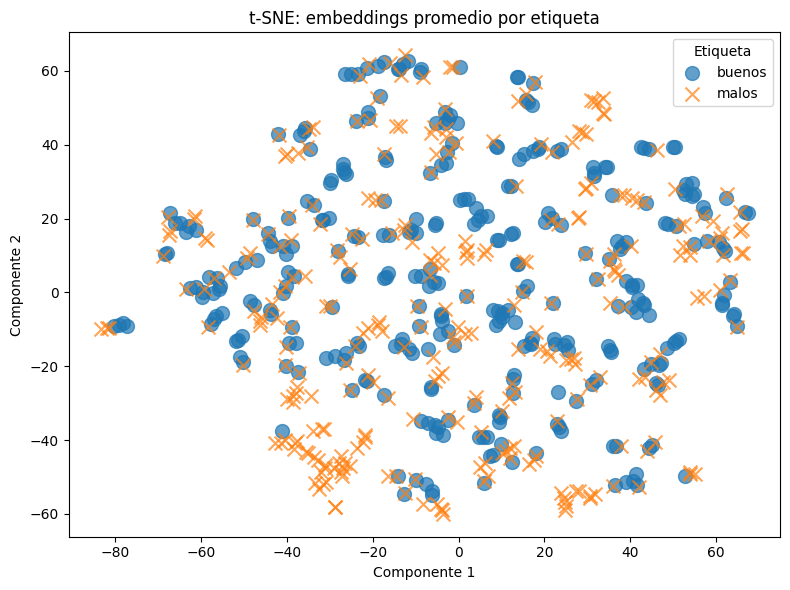

In [10]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Funciones de carga y embedding 

def cargar_wavs_de_carpeta(ruta: str):
    datos = []
    for nombre in sorted(os.listdir(ruta)):
        if not nombre.lower().endswith(".wav"):
            continue
        path = os.path.join(ruta, nombre)
        try:
            audio, sr = librosa.load(path, sr=16000)
            datos.append((audio, nombre))
        except Exception as e:
            print(f" No pude leer '{path}': {e}")
    return datos


def generar_embeddings(datos, extractor, model):
    resultados = []
    for audio, nombre in datos:
        inputs = extractor([audio], sampling_rate=16000, return_tensors="pt", padding=True)
        with torch.no_grad():
            out = model(**inputs)
            vec = out.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        resultados.append((nombre, vec))
    return resultados

# Función robusta de extracción de palabra

def extraer_palabra_pura(nombre):
    # 1) Quitar extensión
    base = os.path.splitext(nombre)[0]
    # 2) Normalizar NFKD y eliminar diacríticos (é → e, ñ → n, etc.)
    nfkd = unicodedata.normalize('NFKD', base)
    sin_tildes = "".join(c for c in nfkd if not unicodedata.combining(c))
    # 3) Minusculas
    sin_tildes = sin_tildes.lower()
    # 4) Quitar TODO lo que no sea letra a–z
    solo_letras = re.sub(r'[^a-z]', '', sin_tildes)
    return solo_letras

# Promedio y verificación 

def promedio_por_palabra(embs):
    grupos = defaultdict(list)
    for nombre, vec in embs:
        clave = extraer_palabra_pura(nombre)
        grupos[clave].append(vec)

    # Verificación exhaustiva
    total_original = len(embs)
    total_agrupado = sum(len(vs) for vs in grupos.values())
    assert total_original == total_agrupado, (
        f"¡Pérdida/duplicado! original={total_original}, agrupado={total_agrupado}"
    )

    # Calcular promedios
    return { clave: np.stack(vs,0).mean(axis=0) for clave, vs in grupos.items() }


# TSNE simplificado 

def visualizar_tsne_conjunto(avg_dicts):
    vectores, etiquetas = [], []
    for etiqueta, d in avg_dicts.items():
        for vec in d.values():
            vectores.append(vec)
            etiquetas.append(etiqueta)
    X = np.stack(vectores, axis=0)
    X2 = TSNE(n_components=2, perplexity=5, random_state=42).fit_transform(X)

    plt.figure(figsize=(8,6))
    for etiqueta, marker in [('buenos','o'), ('malos','x')]:
        mask = np.array(etiquetas) == etiqueta
        plt.scatter(X2[mask,0], X2[mask,1], label=etiqueta,
                    marker=marker, alpha=0.7, s=100)
    plt.legend(title="Etiqueta")
    plt.title("t-SNE: embeddings promedio por etiqueta")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.tight_layout()
    plt.show()



def main():
    rutas = {"buenos": "./Audios_Buenos", "malos": "./Audios_Malos"}
    extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")
    model     = WavLMModel.from_pretrained("microsoft/wavlm-base-plus", use_safetensors=True)
    model.eval()

    resultados = {}
    for etiqueta, ruta in rutas.items():
        if not os.path.isdir(ruta):
            raise FileNotFoundError(f"No existe: {ruta}")
        print(f"→ Procesando: {etiqueta}")
        datos = cargar_wavs_de_carpeta(ruta)
        embs = generar_embeddings(datos, extractor, model)
        avg = promedio_por_palabra(embs)
        resultados[etiqueta] = avg
        print(f"   • {len(avg)} embeddings promedio para '{etiqueta}'")
    return resultados

if __name__ == "__main__":
    avg_embeddings = main()

    # Construir DataFrame de promedio final
    rows = []
    for etiqueta, sub in avg_embeddings.items():
        for palabra, vec in sub.items():
            rows.append({
                'etiqueta': etiqueta,
                'palabra': palabra,
                'dimensión': vec.shape[0]
            })
    df_agg = pd.DataFrame(rows)

    # Verificaciones
    assert not df_agg.duplicated(subset=['etiqueta','palabra']).any(), "Hay duplicados en df_agg"

    # Mostrar resultados agregados
    pd.set_option('display.max_rows', None)
    print(df_agg)
    print("\nConteo por etiqueta:")
    print(df_agg['etiqueta'].value_counts())

    # Listar diferencias
    buenos = set(df_agg[df_agg['etiqueta']=='buenos']['palabra'])
    malos  = set(df_agg[df_agg['etiqueta']=='malos']['palabra'])
    print("\nSolo en buenos:", sorted(buenos - malos))
    print("\nSolo en malos :", sorted(malos - buenos))

    # Visualizar t-SNE
    visualizar_tsne_conjunto(avg_embeddings)



In [11]:
buenos = set(df.loc[df['etiqueta']=='buenos', 'palabra'])
malos  = set(df.loc[df['etiqueta']=='malos',  'palabra'])

solo_en_buenos = sorted(buenos - malos)
solo_en_malos  = sorted(malos  - buenos)
print(f"Palabras SOLO en 'buenos' (n={len(solo_en_buenos)}):")
for w in solo_en_buenos:
    print("  ", w)

print(f"\nPalabras SOLO en 'malos' (n={len(solo_en_malos)}):")
for w in solo_en_malos:
    print("  ", w)

df_diff = pd.DataFrame([
    {"palabra": w, "solo_en": "buenos"} for w in solo_en_buenos
] + [
    {"palabra": w, "solo_en": "malos"}  for w in solo_en_malos
])
pd.set_option('display.max_rows', None)
print("\nDiferencias en DataFrame:")
df_diff


NameError: name 'df' is not defined

In [10]:
X - mostrar embedings con tsne 
grid search para los modelos 
validación cruzada 

4 modelos:
1. Con embedings svm y perceptron multicapa
2.vector con svm y perceptron 
3 embedigs + vector con svm y perceptron multicapa 
4.vector + embedings con svm y perceptron multica 

gráficar funcion de perdida 


SyntaxError: invalid decimal literal (241350753.py, line 6)

In [1]:

labels = [label for label, emb, nombre in embeddings]
X      = np.stack([emb for _, emb, _ in embeddings])
y_text = np.array(labels)

print(len(X[0]),X[0])
# Codifica etiquetas a números (0 y 1)
le    = LabelEncoder().fit(y_text)
y_num = le.transform(y_text)   # 0,1

#Define el CV de 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV para SVM (optimiza sobre accuracy)
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    SVC())
])
param_grid_svm = {
    'svc__kernel': ['linear','rbf'],
    'svc__C':      [0.1, 1, 10],
    'svc__gamma':  ['scale','auto']
}
gs_svm = GridSearchCV(
    pipe_svm,
    param_grid_svm,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
gs_svm.fit(X, y_num)
svm_params = {k.split('__')[1]: v for k, v in gs_svm.best_params_.items()}

# GridSearchCV para MLP (optimiza sobre accuracy)
pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp',    MLPClassifier(max_iter=500, random_state=42))
])
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(100,), (100,100), (200,)],
    'mlp__activation':         ['relu','tanh'],
    'mlp__alpha':              [1e-4, 1e-3]
}
gs_mlp = GridSearchCV(
    pipe_mlp,
    param_grid_mlp,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
gs_mlp.fit(X, y_num)
mlp_params = {k.split('__')[1]: v for k, v in gs_mlp.best_params_.items()}

# valúa por fold: accuracy, hinge loss (SVM) y log loss (MLP)
acc_svm, loss_svm = [], []
acc_mlp, loss_mlp = [], []

for train_idx, test_idx in cv.split(X, y_num):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y_num[train_idx], y_num[test_idx]

    # Entrena con mejores hiperparámetros
    svm_model = Pipeline([
        ('scaler', StandardScaler()),
        ('svc',    SVC(**svm_params))
    ])
    mlp_model = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp',    MLPClassifier(
            max_iter=500,
            random_state=42,
            **mlp_params
        ))
    ])
    svm_model.fit(X_tr, y_tr)
    mlp_model.fit(X_tr, y_tr)

    # Predicciones y scores
    y_pred_s = svm_model.predict(X_te)
    dec_s    = svm_model.decision_function(X_te)  # margen
    y_pred_m = mlp_model.predict(X_te)
    prob_m   = mlp_model.predict_proba(X_te)

    # Accuracy
    acc_svm.append( accuracy_score(y_te, y_pred_s) )
    acc_mlp.append( accuracy_score(y_te, y_pred_m) )

    # Hinge loss manual con etiquetas 0/1
    hl = np.mean( np.maximum(0, 1 - (2*y_te-1) * dec_s) )
    loss_svm.append( hl )

    # Log loss normal
    loss_mlp.append( log_loss(y_te, prob_m) )

s
folds = np.arange(1, 6)
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(folds, acc_svm, '-o', label='SVM')
plt.plot(folds, acc_mlp, '-o', label='MLP')
plt.title('Accuracy por Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(folds, loss_svm, '-o', label='SVM (hinge)')
plt.plot(folds, loss_mlp, '-o', label='MLP (log loss)')
plt.title('Pérdida por Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'embeddings' is not defined

In [76]:
lista = []
for d in df["palabra"]:
    if d not in lista:
        lista.append(d)

print(len(lista))
print(lista)
        

333
['abeja', 'abuela', 'abuelo', 'acahual', 'aceite', 'adentro', 'agua', 'aguacate', 'aguamiel', 'aguila', 'agujerohoyo', 'aire', 'ala', 'alberjon', 'almohada', 'alto', 'amarillo', 'anillo', 'arado', 'arana', 'arbol', 'arcoiris', 'arena', 'arete', 'asno', 'atole', 'aventador', 'ayate', 'azucar', 'azucarera', 'ano', 'bailar', 'barba', 'barbechar', 'barriga', 'bateademadera', 'beber', 'bebe', 'bicol', 'blanco', 'boca', 'borrego', 'boton', 'bozaltempoxa', 'brincar', 'caballo', 'cabello', 'cabeza', 'cajete', 'calabaza', 'calcetinmedia', 'calientedia', 'calzondemanta', 'camino', 'camote', 'campo', 'cantar', 'capulin', 'cara', 'carbon', 'carne', 'carro', 'casa', 'cazuela', 'cana', 'cebada', 'ceniza', 'cerro', 'cenidor', 'chahuistle', 'chango', 'chapulin', 'chayote', 'chicharron', 'chicle', 'chinamite', 'chinche', 'chiquepextle', 'chiquihuite', 'chiquito', 'chismoso', 'cielo', 'cigarro', 'cinco', 'cobija', 'cocina', 'codo', 'collar', 'comal', 'comida', 'conejo', 'contar', 'coserbordar', 'cos